In [ ]:
import sys

# install uplift library scikit-uplift and other libraries 
!{sys.executable} -m pip install scikit-uplift dill lightgbm
!pip install causalml
!pip install pylift
!pip install catboost

In [ ]:
from sklift.datasets import fetch_criteo
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklift.models import TwoModels
import lightgbm as lgb
from sklift.metrics import qini_auc_score
from sklift.viz import plot_qini_curve


# import dask.dataframe as dd
import numpy as np
import scipy as sp

import causalml
import causalml.metrics as cmetrics
import causalml.inference.tree as ctree
import causalml.inference.meta.xlearner as xlearner
import causalml.inference.meta.rlearner as rlearner
import causalml.inference.meta.tlearner as tlearner
import causalml.inference.meta.slearner as slearner

from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor
from xgboost import XGBRegressor, XGBClassifier



import pylift
import catboost as cb
import lightgbm as lgb

from sklearn.model_selection import train_test_split

from IPython.display import Image

seed=10

from scipy.stats import chi2_contingency
from typing import List, Tuple


# Generate synthetic data using mode 1
from causalml.dataset import *
from causalml.metrics import *

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from sklift.metrics import weighted_average_uplift
from sklift.metrics import uplift_auc_score
from sklift.metrics import qini_auc_score
from sklift.metrics import uplift_at_k

In [ ]:
from causalml.dataset import *
from causalml.metrics import *

y, X, treatment, tau, b, e = synthetic_data(mode=5, n=10000, p=8, sigma=1.0)

treatment = np.array([('treatment_a' if np.random.random() > 0.2 else 'treatment_b') 
                      if val==1 else 'control' for val in treatment])

e = {group: e for group in np.unique(treatment)}

In [ ]:
pd.Series(treatment).value_counts()

control        4933
treatment_a    4088
treatment_b     979
dtype: int64

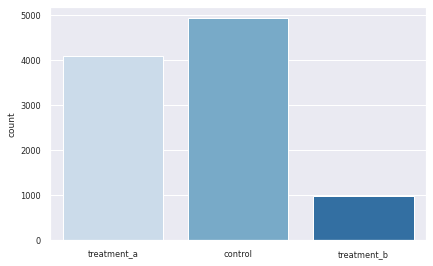

In [ ]:
sns.countplot(x=pd.Series(treatment), palette = "Blues")

In [ ]:
target = pd.Series(y)
target.name = 'y'

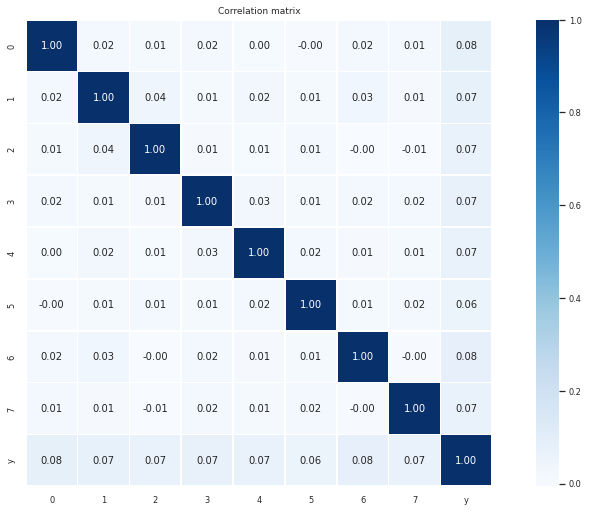

In [ ]:
plt.figure(figsize = (14,8))
sns.set(font_scale=0.75)
sns.heatmap(pd.DataFrame(X).join(target).corr().round(3), annot=True, square = True, \
    linewidths=.75, cmap="Blues", fmt = ".2f", annot_kws = {"size": 10} )
plt.title("Correlation matrix")
plt.show()

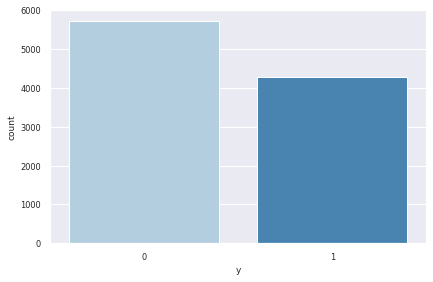

In [ ]:
sns.countplot(x=target, palette = "Blues")

In [ ]:
target.value_counts()

0    5719
1    4281
Name: y, dtype: int64

In [ ]:
treatment = pd.Series(treatment).apply(lambda t: 0 if t == 'control'  else (1 if t == 'treatment_a' else 2)).astype('float')

In [ ]:
pd.Series(treatment).value_counts()

0.0    5012
1.0    3924
2.0    1064
dtype: int64

In [ ]:
X_train, X_val, trmnt_train, trmnt_val, y_train, y_val = train_test_split(
    X,
    treatment,
    target,
    test_size=0.3,
    random_state=31
)

print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")

Train shape: (7000, 8)
Validation shape: (3000, 8)


In [ ]:
df_all_scores = pd.DataFrame()
df_all_metrics= pd.DataFrame()

df_all_metrics['model'] = 'default'
df_all_metrics['ATE_1'] = 'default'
df_all_metrics['ATE_2'] = 'default'

In [ ]:
df_all_scores_1 = pd.DataFrame()
df_all_scores_2 = pd.DataFrame()

In [ ]:
learner_s = BaseSRegressor(XGBRegressor(), control_name=0)
ate_s = learner_s.estimate_ate(X=X_train, treatment=trmnt_train, y=y_train, return_ci=False, bootstrap_ci=False)
print(ate_s)
print(learner_s._classes)

learner_s.fit(
    X=X_train,
    treatment=trmnt_train,
    y=y_train
)

s_learner_pred = pd.DataFrame(learner_s.predict(X_val))
s_learner_pred = s_learner_pred.rename(columns={0:'score'})

s_learner_pred = s_learner_pred.join(pd.Series(trmnt_val).rename('treatment').reset_index(drop=True)) # ['treatment']
s_learner_pred = s_learner_pred.join(pd.Series(y_val).rename('target').reset_index(drop=True)) # ['visit']

cols = ['score', 1]
s_learner_pred['S-Learner'] = s_learner_pred[cols].max(axis=1)

df_all_scores_1['S-Learner'] = s_learner_pred['score']
df_all_scores_2['S-Learner'] = s_learner_pred[1]

s_learner_pred = s_learner_pred.drop('score', axis=1)
s_learner_pred = s_learner_pred.drop(1, axis=1)


# add scores to total df
df_all_scores['s_learner_pred'] = s_learner_pred['S-Learner']
# add metrics to total df 
df_all_metrics = df_all_metrics.append({ 
                       'model' : 'S-Learner',
                       'ATE_1' : ate_s[0],
                       'ATE_2' : ate_s[1]
}, ignore_index=True)

print(df_all_scores.shape, df_all_metrics.shape)

# plt.figure(figsize=(8, 8))
# plt.hist(s_learner_pred['S-Learner'], range=(0, 1.5), bins=100)
# plt.xlabel("Предсказанное значение Uplift. Модель S-Learner")
# plt.ylabel("Количество объектов в валидационной выборке")
# plt.show()

[00:18:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:18:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.80891027 0.79421125]
{1.0: 0, 2.0: 1}
[00:18:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:18:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
(3000, 1) (1, 3)


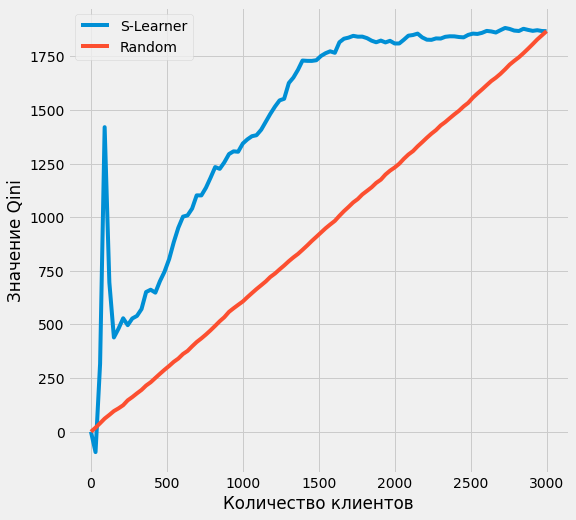

In [ ]:
# sns.set_style("whitegrid")

# plt.figure(figsize=(8, 8))
cmetrics.plot_qini(
    s_learner_pred,
    treatment_col='treatment',
    outcome_col='target'
)
plt.xlabel("Количество клиентов")
plt.ylabel("Значение Qini")
plt.show()

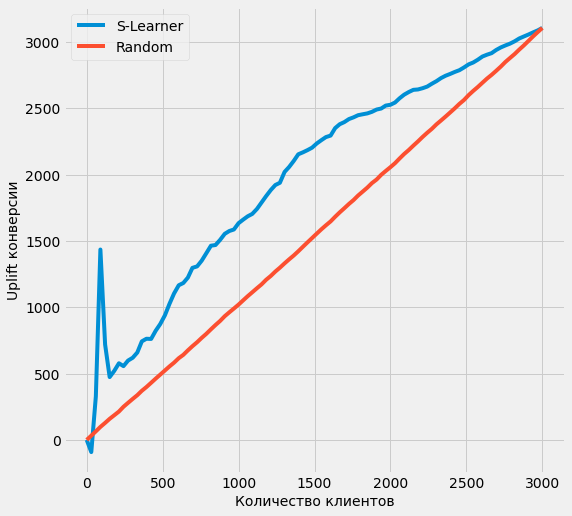

In [ ]:
cmetrics.plot_gain(
    s_learner_pred,
    treatment_col='treatment',
    outcome_col='target'
)
plt.xlabel("Количество клиентов", fontsize=14)
plt.ylabel("Uplift конверсии", fontsize=14)
plt.show()

In [ ]:
df_all_metrics.head()

,model,ATE_1,ATE_2
0,S-Learner,0.821407,0.811806


In [ ]:
df_all_metrics = df_all_metrics.drop(2, axis=0)

In [ ]:
df_all_scores.head()

,s_learner_pred
0,0.850957
1,0.753171
2,0.899487
3,0.974177
4,0.840418


In [ ]:
learner_t = BaseTRegressor(XGBRegressor(), control_name=0)
ate_t, ate_t_lb, ate_t_ub = learner_t.estimate_ate(X=X_train, treatment=trmnt_train, y=y_train)
print(ate_t)
print(learner_t._classes)

learner_t.fit(
    X=X_train,
    treatment=trmnt_train,
    y=y_train
)

t_learner_pred = pd.DataFrame(learner_t.predict(X_val))
t_learner_pred = t_learner_pred.rename(columns={0:'score'})

t_learner_pred = t_learner_pred.join(pd.Series(trmnt_val).rename('treatment').reset_index(drop=True)) # ['treatment']
t_learner_pred = t_learner_pred.join(pd.Series(y_val).rename('target').reset_index(drop=True)) # ['visit']

cols = ['score', 1]
t_learner_pred['T-Learner'] = t_learner_pred[cols].max(axis=1)

df_all_scores_1['T-Learner'] = t_learner_pred['score']
df_all_scores_2['T-Learner'] = t_learner_pred[1]

t_learner_pred = t_learner_pred.drop('score', axis=1)
t_learner_pred = t_learner_pred.drop(1, axis=1)


# add scores to total df
df_all_scores['t_learner_pred'] = t_learner_pred['T-Learner']
# add metrics to total df 
df_all_metrics = df_all_metrics.append({ 
                       'model' : 'T-Learner',
                       'ATE_1' : ate_t[0],
                       'ATE_2' : ate_t[1]
}, ignore_index=True)

print(df_all_scores.shape, df_all_metrics.shape)

# plt.figure(figsize=(8, 8))
# plt.hist(t_learner_pred['T-Learner'], range=(0, 1.5), bins=100)
# plt.xlabel("Предсказанное значение Uplift. Модель T-Learner")
# plt.ylabel("Количество объектов в валидационной выборке")
# plt.show()

[00:19:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.79783764 0.77998501]
{1.0: 0, 2.0: 1}
[00:19:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:20] WARNING: /workspace/src/objective/regression_obj.cu:152: re

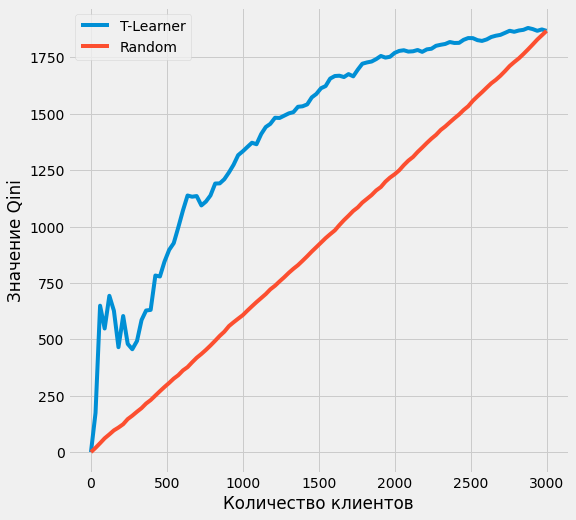

In [ ]:
cmetrics.plot_qini(
    t_learner_pred,
    treatment_col='treatment',
    outcome_col='target'
)
plt.xlabel("Количество клиентов")
plt.ylabel("Значение Qini")
plt.show()

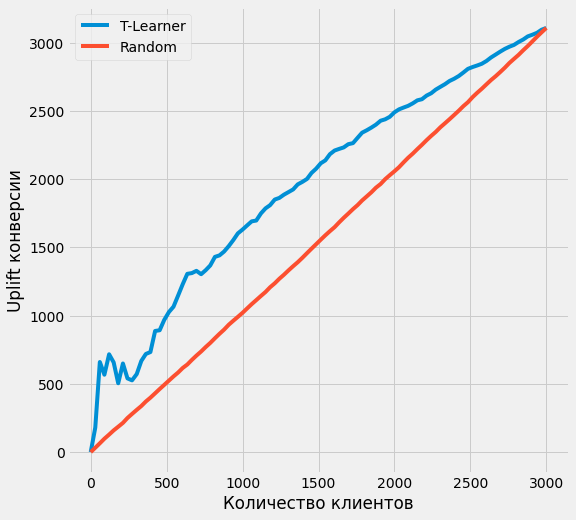

In [ ]:
cmetrics.plot_gain(
    t_learner_pred,
    treatment_col='treatment',
    outcome_col='target'
)
plt.xlabel("Количество клиентов")
plt.ylabel("Uplift конверсии")
plt.show()

In [ ]:
learner_x = BaseXRegressor(XGBRegressor(), control_name=0)
ate_t, ate_t_lb, ate_t_ub = learner_x.estimate_ate(X=X_train, treatment=trmnt_train, y=y_train)
print(ate_t)
print(learner_x._classes)

learner_x.fit(
    X=X_train,
    treatment=trmnt_train,
    y=y_train
)

x_learner_pred = pd.DataFrame(learner_x.predict(X_val))
x_learner_pred = x_learner_pred.rename(columns={0:'score'})

x_learner_pred = x_learner_pred.join(pd.Series(trmnt_val).rename('treatment').reset_index(drop=True)) # ['treatment']
x_learner_pred = x_learner_pred.join(pd.Series(y_val).rename('target').reset_index(drop=True)) # ['visit']

cols = ['score', 1]
x_learner_pred['X-Learner'] = x_learner_pred[cols].max(axis=1)

df_all_scores_1['X-Learner'] = x_learner_pred['score']
df_all_scores_2['X-Learner'] = x_learner_pred[1]

x_learner_pred = x_learner_pred.drop('score', axis=1)
x_learner_pred = x_learner_pred.drop(1, axis=1)


# add scores to total df
df_all_scores['x_learner_pred'] = x_learner_pred['X-Learner']
# add metrics to total df 
df_all_metrics = df_all_metrics.append({ 
                       'model' : 'X-Learner',
                       'ATE_1' : ate_t[0],
                       'ATE_2' : ate_t[1]
}, ignore_index=True)

print(df_all_scores.shape, df_all_metrics.shape)

# plt.figure(figsize=(8, 8))
# plt.hist(x_learner_pred['X-Learner'], range=(0, 1.5), bins=100)
# plt.xlabel("Предсказанное значение Uplift. Модель X-Learner")
# plt.ylabel("Количество объектов в валидационной выборке")
# plt.show()

[00:19:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

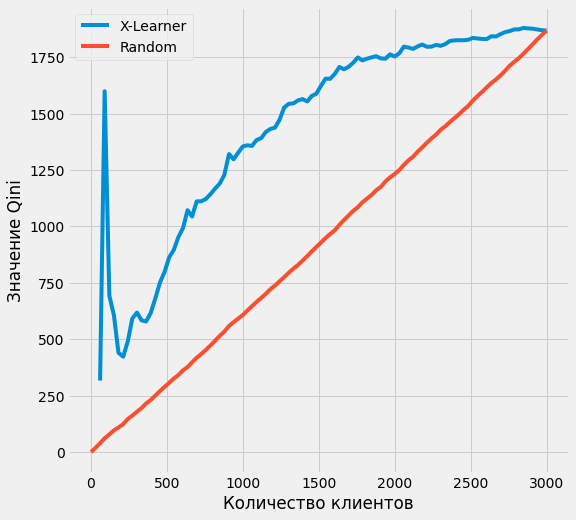

In [ ]:
cmetrics.plot_qini(
    x_learner_pred,
    treatment_col='treatment',
    outcome_col='target'
)
plt.xlabel("Количество клиентов")
plt.ylabel("Значение Qini")
plt.show()

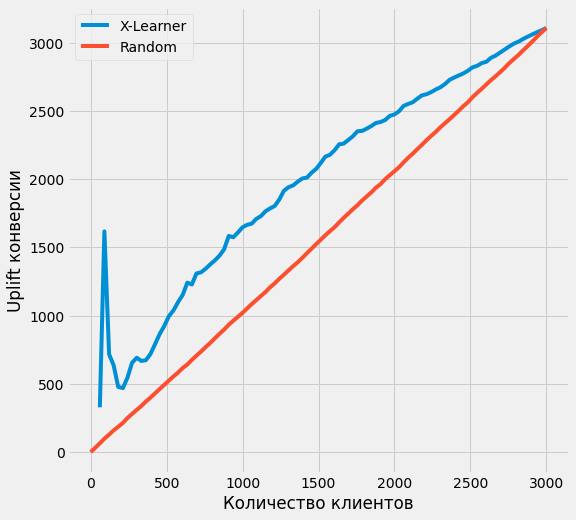

In [ ]:
cmetrics.plot_gain(
    x_learner_pred,
    treatment_col='treatment',
    outcome_col='target'
)
plt.xlabel("Количество клиентов")
plt.ylabel("Uplift конверсии")
plt.show()

In [ ]:
learner_r = BaseRRegressor(XGBRegressor(), control_name=0)
ate_t, ate_t_lb, ate_t_ub = learner_r.estimate_ate(X=X_train, treatment=trmnt_train, y=y_train)
print(ate_t)
print(learner_r._classes)

learner_r.fit(
    X=X_train,
    treatment=trmnt_train,
    y=y_train
)

r_learner_pred = pd.DataFrame(learner_r.predict(X_val))
r_learner_pred = r_learner_pred.rename(columns={0:'score'})

r_learner_pred = r_learner_pred.join(pd.Series(trmnt_val).rename('treatment').reset_index(drop=True)) # ['treatment']
r_learner_pred = r_learner_pred.join(pd.Series(y_val).rename('target').reset_index(drop=True)) # ['visit']

cols = ['score', 1]
r_learner_pred['R-Learner'] = r_learner_pred[cols].max(axis=1)

df_all_scores_1['R-Learner'] = r_learner_pred['score']
df_all_scores_2['R-Learner'] = r_learner_pred[1]

r_learner_pred = r_learner_pred.drop('score', axis=1)
r_learner_pred = r_learner_pred.drop(1, axis=1)


# add scores to total df
df_all_scores['r_learner_pred'] = r_learner_pred['R-Learner']
# add metrics to total df 
df_all_metrics = df_all_metrics.append({ 
                       'model' : 'R-Learner',
                       'ATE_1' : ate_t[0],
                       'ATE_2' : ate_t[1]
}, ignore_index=True)

print(df_all_scores.shape, df_all_metrics.shape)

# plt.figure(figsize=(8, 8))
# plt.hist(r_learner_pred['R-Learner'], range=(0, 1.5), bins=100)
# plt.xlabel("Предсказанное значение Uplift. Модель R-Learner")
# plt.ylabel("Количество объектов в валидационной выборке")
# plt.show()

[00:20:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:20:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.72247552 0.63172359]
{1.0: 0, 2.0: 1}
[00:20:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:20:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
(3000, 4) (4, 3)


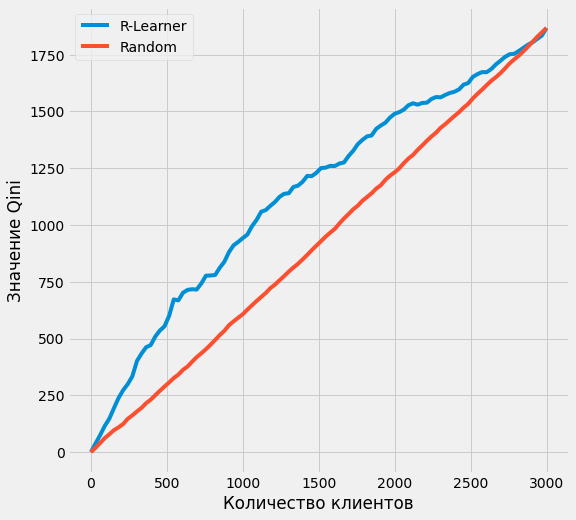

In [ ]:
cmetrics.plot_qini(
    r_learner_pred,
    treatment_col='treatment',
    outcome_col='target'
)
plt.xlabel("Количество клиентов")
plt.ylabel("Значение Qini")
plt.show()

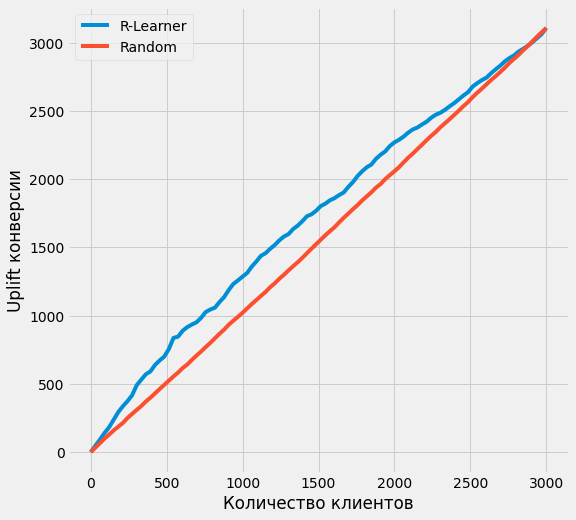

In [ ]:
cmetrics.plot_gain(
    r_learner_pred,
    treatment_col='treatment',
    outcome_col='target'
)
plt.xlabel("Количество клиентов")
plt.ylabel("Uplift конверсии")
plt.show()

In [ ]:
df_all_metrics.head()

,model,ATE_1,ATE_2
0,S-Learner,0.808910,0.794211
1,T-Learner,0.797838,0.779985
2,X-Learner,0.795840,0.779649
3,R-Learner,0.722476,0.631724


In [ ]:
df_all_scores.head()

,s_learner_pred,t_learner_pred,x_learner_pred,r_learner_pred
0,0.872547,0.831720,0.850911,0.815429
1,0.704677,0.611978,0.627294,0.658464
2,0.823110,0.877560,0.865139,0.825899
3,0.692095,0.633031,0.639773,0.669114
4,0.792509,0.771186,0.769559,0.671073


In [ ]:
df_all_scores = df_all_scores.join(pd.Series(trmnt_val).rename('treatment').reset_index(drop=True))
df_all_scores = df_all_scores.join(pd.Series(y_val).rename('target').reset_index(drop=True))
print(df_all_scores.shape)

(3000, 6)


In [ ]:
df_all_scores.columns = ['S-Learner', 'T-Learner', 'X-Learner', 'R-Learner', 'treatment', 'target']

In [ ]:
df_all_metrics.head()

,model,ATE_1,ATE_2
0,S-Learner,0.808910,0.794211
1,T-Learner,0.797838,0.779985
2,X-Learner,0.795840,0.779649
3,R-Learner,0.722476,0.631724


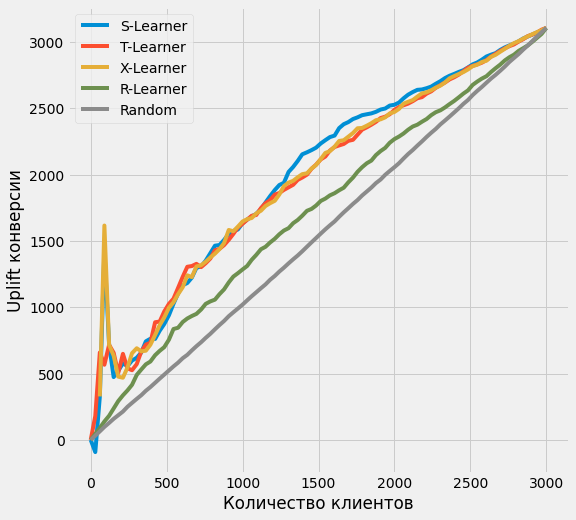

In [ ]:
cmetrics.plot_gain(
    df_all_scores,
    treatment_col='treatment',
    outcome_col='target'
)
plt.xlabel("Количество клиентов")
plt.ylabel("Uplift конверсии")
plt.show()

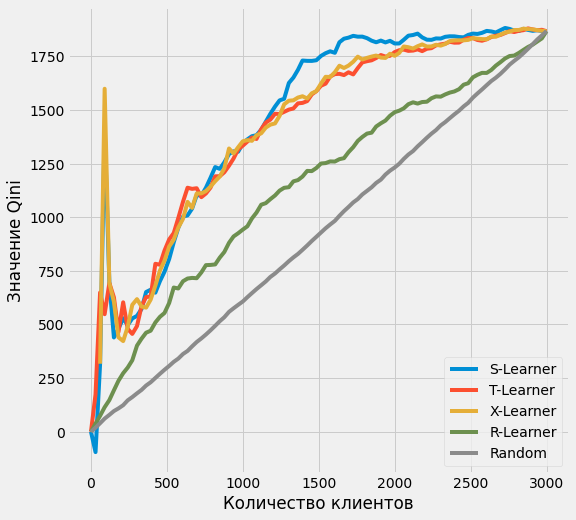

In [ ]:
cmetrics.plot_qini(
    df_all_scores,
    treatment_col='treatment',
    outcome_col='target'
)
plt.xlabel("Количество клиентов")
plt.ylabel("Значение Qini")
plt.show()

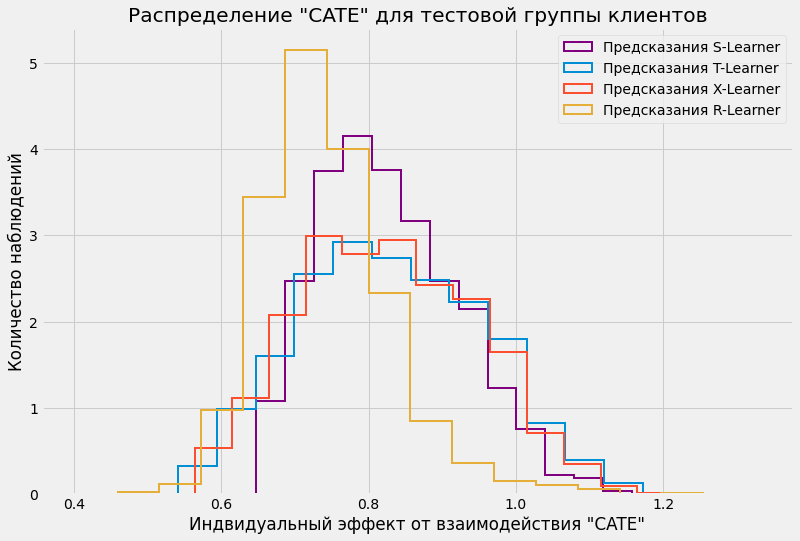

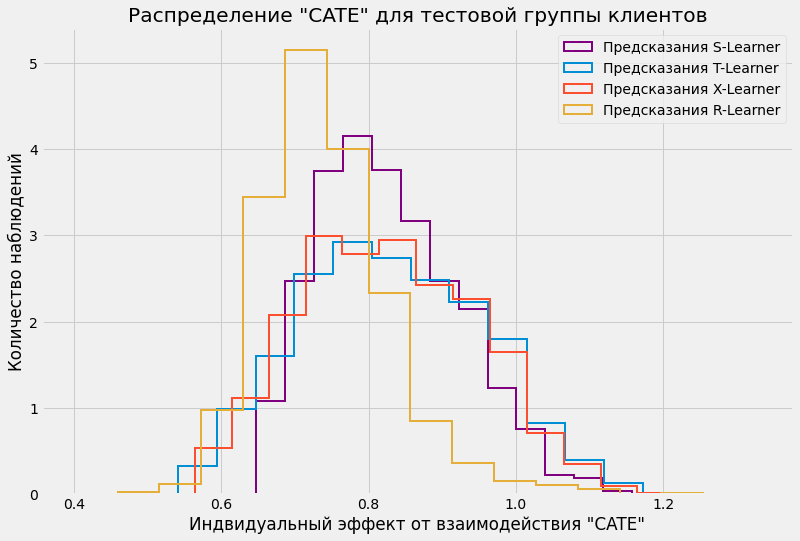

In [ ]:
groups = learner_r._classes

alpha = 1
linewidth = 2
bins = 15

for group,idx in sorted(groups.items(), key=lambda x: x[1]):
    plt.figure(figsize=(12,8))
    plt.hist(df_all_scores['S-Learner'], alpha=alpha, bins=bins, label='Предсказания S-Learner',
             histtype='step', linewidth=linewidth, density=True, color='purple',)
    plt.hist(df_all_scores['T-Learner'], alpha=alpha, bins=bins, label='Предсказания T-Learner',
             histtype='step', linewidth=linewidth, density=True)
    plt.hist(df_all_scores['X-Learner'], alpha=alpha, bins=bins, label='Предсказания X-Learner',
             histtype='step', linewidth=linewidth, density=True)
    plt.hist(df_all_scores['R-Learner'], alpha=alpha, bins=bins, label='Предсказания R-Learner',
             histtype='step', linewidth=linewidth, density=True)
    # plt.hist(tau, alpha=alpha, bins=bins, label='Настоящее распределение "CATE"',
    #          histtype='step', linewidth=linewidth, color='green', density=True)
    # plt.vlines(tau.mean(), 0, plt.axes().get_ylim()[1], label='Среднее настоящее "CATE"',
    #            linestyles='dotted', linewidth=linewidth, color='green')
    
    plt.title('Распределение "CATE" для тестовой группы клиентов')
    plt.xlabel('Индвидуальный эффект от взаимодействия "CATE"')
    plt.ylabel('Количество наблюдений')
    _=plt.legend()

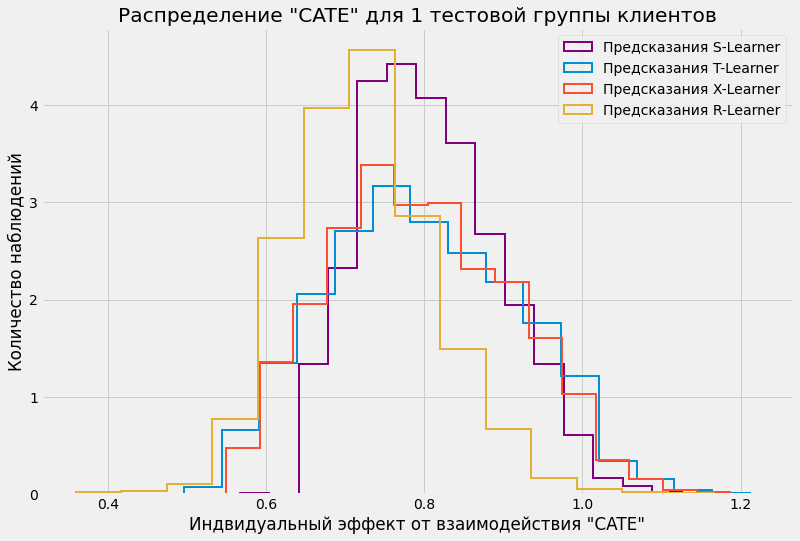

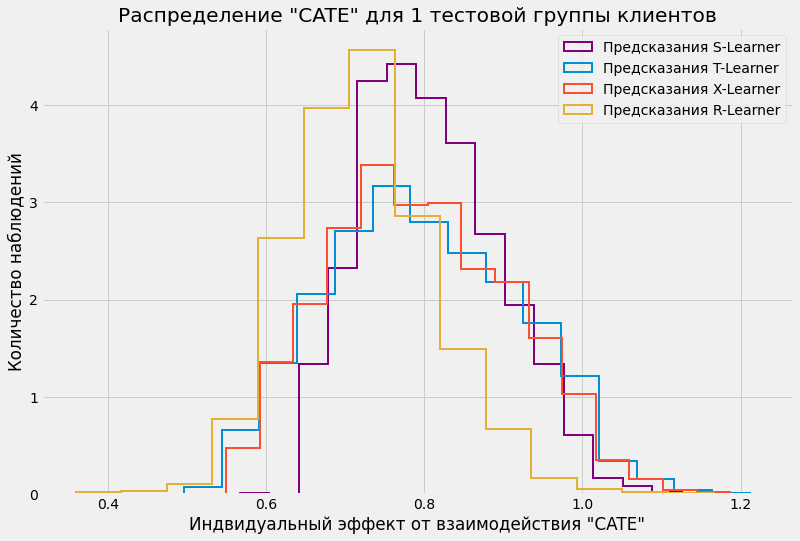

In [ ]:
groups = learner_r._classes

alpha = 1
linewidth = 2
bins = 15

for group,idx in sorted(groups.items(), key=lambda x: x[1]):
    plt.figure(figsize=(12,8))
    plt.hist(df_all_scores_1['S-Learner'], alpha=alpha, bins=bins, label='Предсказания S-Learner',
             histtype='step', linewidth=linewidth, density=True, color='purple',)
    plt.hist(df_all_scores_1['T-Learner'], alpha=alpha, bins=bins, label='Предсказания T-Learner',
             histtype='step', linewidth=linewidth, density=True)
    plt.hist(df_all_scores_1['X-Learner'], alpha=alpha, bins=bins, label='Предсказания X-Learner',
             histtype='step', linewidth=linewidth, density=True)
    plt.hist(df_all_scores_1['R-Learner'], alpha=alpha, bins=bins, label='Предсказания R-Learner',
             histtype='step', linewidth=linewidth, density=True)
    # plt.hist(tau, alpha=alpha, bins=bins, label='Настоящее распределение "CATE"',
    #          histtype='step', linewidth=linewidth, color='green', density=True)
    # plt.vlines(tau.mean(), 0, plt.axes().get_ylim()[1], label='Среднее настоящее "CATE"',
    #            linestyles='dotted', linewidth=linewidth, color='green')
    
    plt.title('Распределение "CATE" для 1 тестовой группы клиентов')
    plt.xlabel('Индвидуальный эффект от взаимодействия "CATE"')
    plt.ylabel('Количество наблюдений')
    _=plt.legend()

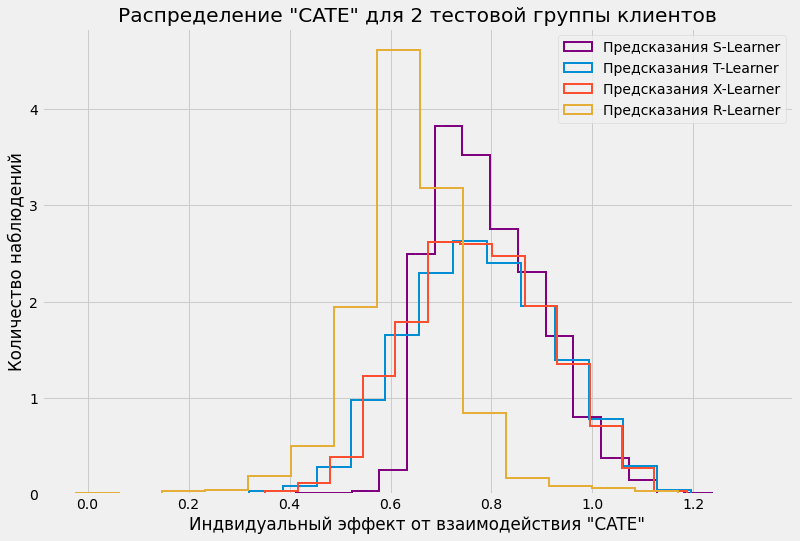

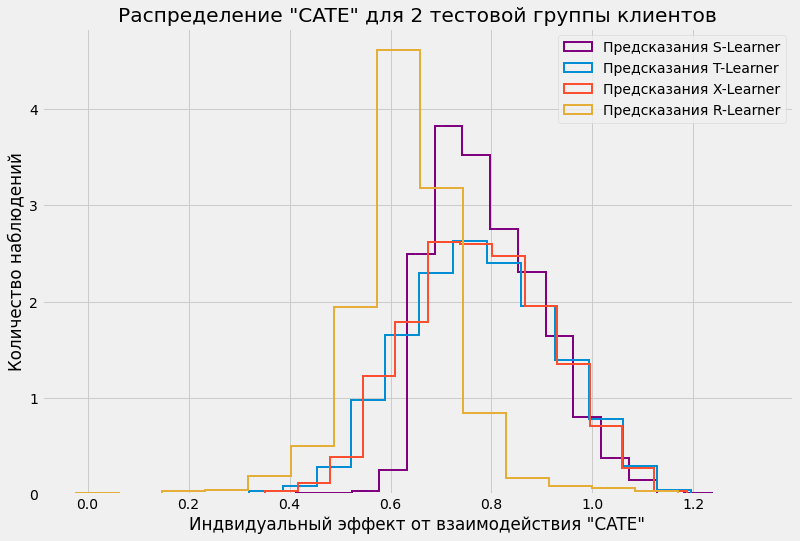

In [ ]:
groups = learner_r._classes

alpha = 1
linewidth = 2
bins = 15

for group,idx in sorted(groups.items(), key=lambda x: x[1]):
    plt.figure(figsize=(12,8))
    plt.hist(df_all_scores_2['S-Learner'], alpha=alpha, bins=bins, label='Предсказания S-Learner',
             histtype='step', linewidth=linewidth, density=True, color='purple',)
    plt.hist(df_all_scores_2['T-Learner'], alpha=alpha, bins=bins, label='Предсказания T-Learner',
             histtype='step', linewidth=linewidth, density=True)
    plt.hist(df_all_scores_2['X-Learner'], alpha=alpha, bins=bins, label='Предсказания X-Learner',
             histtype='step', linewidth=linewidth, density=True)
    plt.hist(df_all_scores_2['R-Learner'], alpha=alpha, bins=bins, label='Предсказания R-Learner',
             histtype='step', linewidth=linewidth, density=True)
    # plt.hist(tau, alpha=alpha, bins=bins, label='Настоящее распределение "CATE"',
    #          histtype='step', linewidth=linewidth, color='green', density=True)
    # plt.vlines(tau.mean(), 0, plt.axes().get_ylim()[1], label='Среднее настоящее "CATE"',
    #            linestyles='dotted', linewidth=linewidth, color='green')
    
    plt.title('Распределение "CATE" для 2 тестовой группы клиентов')
    plt.xlabel('Индвидуальный эффект от взаимодействия "CATE"')
    plt.ylabel('Количество наблюдений')
    _=plt.legend()

In [ ]:

df_all_scores_1['T-Learner'] = t_learner_pred['score']
df_all_scores_2['T-Learner'] = t_learner_pred[1]